## Installazione pacchetti e database

Installazione pacchetto torchio per la gestione delle immagini mediche

In [1]:
!pip install torchio

Creazione collegamento a google drive in cui sono salvate le immagini

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Installazione dei pacchetti necessari al programma

In [3]:
import os
import torch
import torchvision
import tarfile
import multiprocessing
import pandas as pd
import torch.nn as nn
import numpy as np
import os.path

import torchio as tio
import torch.nn.functional as F
import torchvision.transforms as tt
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader

from IPython import display

"""from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'"""

"from torchvision.utils import make_grid\nimport matplotlib\nimport matplotlib.pyplot as plt\n%matplotlib inline\n\nmatplotlib.rcParams['figure.facecolor'] = '#ffffff'"

In [4]:
import os
import torch
import torchvision
import tarfile
import pandas as pd
import torch.nn as nn
import numpy as np
import os.path
import shutil
import torchio as tio
import torch.nn.functional as F
import torchvision.transforms as tt
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
import nibabel as nib
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

Importazione del file csv in cui sono presenti tutti gli ID dei pazienti con i rispettivi overall survival (0 < 450 gg e 1 >= 450 gg)

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Tesi/Progetto/informazioni_pazienti.csv', index_col = 'ID')
print(df)

                    OS
ID                    
UPENN-GBM-00002_11   0
UPENN-GBM-00006_11   1
UPENN-GBM-00008_11   1
UPENN-GBM-00009_11   1
UPENN-GBM-00011_11   1
...                 ..
UPENN-GBM-00597_11   0
UPENN-GBM-00601_11   0
UPENN-GBM-00602_11   0
UPENN-GBM-00604_11   0
UPENN-GBM-00611_11   1

[334 rows x 1 columns]


## Creazione dei dataset (training, validation, testing)

Lista in cui sono presenti tutti gli ID dei pazienti

In [6]:
patients_list = [f.name for f in os.scandir('/content/drive/MyDrive/Tesi/Progetto/dataset') if f.is_dir()]
subjects_list = []
print(patients_list)

['UPENN-GBM-00006_11', 'UPENN-GBM-00009_11', 'UPENN-GBM-00011_11', 'UPENN-GBM-00002_11', 'UPENN-GBM-00014_11', 'UPENN-GBM-00012_11', 'UPENN-GBM-00020_11', 'UPENN-GBM-00016_11', 'UPENN-GBM-00008_11', 'UPENN-GBM-00018_11', 'UPENN-GBM-00040_11', 'UPENN-GBM-00033_11', 'UPENN-GBM-00041_11', 'UPENN-GBM-00021_11', 'UPENN-GBM-00034_11', 'UPENN-GBM-00035_11', 'UPENN-GBM-00031_11', 'UPENN-GBM-00029_11', 'UPENN-GBM-00022_11', 'UPENN-GBM-00030_11', 'UPENN-GBM-00054_11', 'UPENN-GBM-00043_11', 'UPENN-GBM-00059_11', 'UPENN-GBM-00062_11', 'UPENN-GBM-00047_11', 'UPENN-GBM-00060_11', 'UPENN-GBM-00063_11', 'UPENN-GBM-00058_11', 'UPENN-GBM-00045_11', 'UPENN-GBM-00057_11', 'UPENN-GBM-00065_11', 'UPENN-GBM-00068_11', 'UPENN-GBM-00076_11', 'UPENN-GBM-00072_11', 'UPENN-GBM-00077_11', 'UPENN-GBM-00064_11', 'UPENN-GBM-00069_11', 'UPENN-GBM-00073_11', 'UPENN-GBM-00066_11', 'UPENN-GBM-00075_11', 'UPENN-GBM-00082_11', 'UPENN-GBM-00091_11', 'UPENN-GBM-00083_11', 'UPENN-GBM-00081_11', 'UPENN-GBM-00086_11', 'UPENN-GB

Lista in cui sono presenti tutti i soggetti (contenenti l'immagine e l'overall survival)

In [7]:
for current in patients_list:
  image_path = '/content/drive/MyDrive/Tesi/Progetto/dataset/' + current + '/' + current+'_img.nii.gz'
  image_name = current

for current in patients_list:
    subject_dict = {'images': tio.ScalarImage('/content/drive/MyDrive/Tesi/Progetto/dataset/' + current + '/' + current+'_img.nii.gz'),
                    'ImagesName': image_name ,#aggiunto per bilanciamento
                    'OS':  df.loc[current, 'OS']
                   }
    subject = tio.Subject(subject_dict)
    subjects_list.append(subject)

In [8]:
len(subjects_list)

334

Creazione del dataset

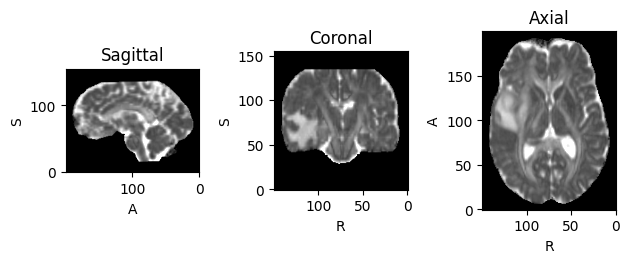


Info paziente "0":  Subject(Keys: ('images', 'ImagesName', 'OS'); images: 1)

Shape:  (6, 150, 200, 155)

Size images:  (1.0, 1.0, 1.0)

Dimensione dataset:  334


In [9]:
subject_dataset = tio.SubjectsDataset(subjects_list)
subject_dataset[0].images.plot()
print('\nInfo paziente "0": ', subject_dataset[0])
print('\nShape: ', subject_dataset[0].images.shape)
print('\nSize images: ', subject_dataset[0].images.spacing)
print('\nDimensione dataset: ', len(subject_dataset))

Funzioni di trasformazioni da applicare ai vari set (richiedono troppe risorse, quindi sono solo state normalizzate)

In [10]:
training_Transform = tio.Compose([
    tio.ToCanonical(),
    tio.Resample(5),
    tio.RandomFlip(),
    #tio.RandomNoise(p = 0.2),
    #tio.RandomMotion(p = 0.2),
    #tio.EnsureShapeMultiple(16, method = 'pad')
])

val_test_Transform = tio.Compose([
    tio.ToCanonical(),
    tio.Resample(5),
    #tio.EnsureShapeMultiple(16, method = 'pad')
])

Separazione del dataset in training (70%), validation (20%) e testing set (10%) applicando le rispettive trasformazioni

In [12]:
val_size = int(round(len(patients_list)*0.2))
train_size = int(round(len(patients_list)*0.7))
test_size = int(round(len(patients_list)*0.1))

random_seed = 11
torch.manual_seed(random_seed)
train_subjs, val_subjs, test_subjs = random_split(subject_dataset, [train_size, val_size, test_size])

train_ds = tio.SubjectsDataset(train_subjs, transform = training_Transform)
val_ds = tio.SubjectsDataset(val_subjs, transform = val_test_Transform)
test_ds = tio.SubjectsDataset(test_subjs, transform = val_test_Transform)

print('Training set: ', len(train_ds), ' pazienti')
print('Validation set: ', len(val_ds), ' pazienti')
print('Testing set: ', len(test_ds), ' pazienti')

Training set:  234  pazienti
Validation set:  67  pazienti
Testing set:  33  pazienti


In [13]:
train_ds[0].images.shape

(6, 30, 40, 31)

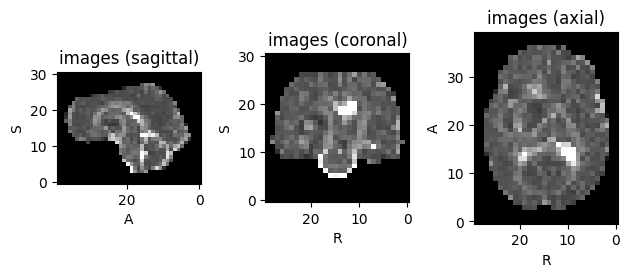

In [14]:
train_ds[0].plot()

In [15]:
class_0_indices = []
class_1_indices = []
for current in train_ds:
    labels = current['OS']
    inputs = current['images'][tio.DATA]
    name = current['ImagesName']

    if ( labels == 0):
        class_0_indices.append(name)
    else:
      class_1_indices.append(name)

print(len(class_0_indices))
print(len(class_1_indices))

class_0_size=len(class_0_indices)
class_1_size=len(class_1_indices)

141
93


In [16]:
subjects_train_0 = []
for current in class_0_indices:
  image_path = '/content/drive/MyDrive/Tesi/Progetto/dataset/' + current + '/' + current+'_img.nii.gz'
  image_name = current

  subject_dict = {'images': tio.ScalarImage('/content/drive/MyDrive/Tesi/Progetto/dataset/' + current + '/' + current+'_img.nii.gz'),
                 'ImagesName': image_name ,
                 'OS': df.loc[current, 'OS']
                 }
  subject = tio.Subject(subject_dict)
  subjects_train_0.append(subject)

In [17]:
subjects_train_1 = []
for current in class_1_indices:
  image_path = '/content/drive/MyDrive/Tesi/Progetto/dataset/' + current + '/' + current+'_img.nii.gz'
  image_name = current

  subject_dict = {'images': tio.ScalarImage('/content/drive/MyDrive/Tesi/Progetto/dataset/' + current + '/' + current+'_img.nii.gz'),
                 'ImagesName': image_name ,
                 'OS': df.loc[current, 'OS']
                 }
  subject = tio.Subject(subject_dict)
  subjects_train_1.append(subject)

In [18]:
min_class = min(len(class_0_indices), len(class_1_indices))
print (min_class)
min_class_indices = class_0_indices if len(class_0_indices) == min_class else class_1_indices

random_seed = 11
torch.manual_seed(random_seed)
train_subjs_0, _ = random_split(subjects_train_0, [min_class, class_0_size - min_class])
train_subjs_1, _ = random_split(subjects_train_1, [min_class, class_1_size - min_class])

train_subjs_bilanciato = tio.SubjectsDataset(train_subjs_0 + train_subjs_1, transform=training_Transform)

93


In [19]:
batch_size=10

In [20]:
train_dl = DataLoader(train_subjs_bilanciato, batch_size, shuffle=True, num_workers = 0)

val_dl = DataLoader(val_ds, batch_size,  shuffle=False, num_workers = 0)

## Funzione per il caricamento nella GPU

In [21]:
# Controllo della presenza di una GPU
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

# Sposta tensori sul device selezionato
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# Passa dataloader sul device
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [22]:
device = get_default_device()
device

device(type='cuda')

## Creazione dei DataLoader

In [23]:
def prepare_batch(batch, device):
    inputs = batch['images'][tio.DATA].to(device)
    #inputs= inputs.reshape(-1,26400)
    labels = batch['OS'].to(device)
    return inputs, labels

In [24]:
cores = multiprocessing.cpu_count()
batch_size = 10
train_dl = DataLoader(train_ds, batch_size, shuffle = True , num_workers = cores, pin_memory = True)
#val_dl = DataLoader(val_ds, batch_size, shuffle= False, num_workers = cores, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size=2*batch_size, shuffle=False)

## Funzioni di training

In [25]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    print('accuracy labels: ', labels)
    print('accuracy preds: ', preds)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [26]:
class_index= 1

In [27]:
def precision(outputs, labels, class_index):
    _, preds = torch.max(outputs, dim=1) #stiamo assegnando solo l'output degli indici a preds utilizzando l'underscore _ per ignorare l'output dei valori massimi.
    print('\nprecision targets: ', labels)
    print('\nprecision preds: ', preds)



    class_preds = torch.eq(torch.tensor(preds), torch.tensor(class_index))
    class_labels = torch.eq(torch.tensor(labels), torch.tensor(class_index)) #stessa cosa, confronta labels e class index, se sono uguali true(1), diversi false(0)

    true_positives = torch.logical_and(class_preds, class_labels).sum().item() # se label e preds sono 1 allora sono veri positivi
    total_positives = class_preds.sum().item() #tutte le previsioni che ti vengono uguali a 1

    precision = true_positives / total_positives if total_positives != 0 else 0

    return torch.tensor(precision)

In [28]:
class ImageClassification(nn.Module):
    def training_step(self, batch):
        images = batch['images'][tio.DATA].to(device)
        targets = batch['OS'].to(device)
        out = self(images)
        print('training step targets: ', targets)
        print('training step outputs: ')
        print(out)
        loss = F.cross_entropy(out, targets)
        return loss

    def validation_step(self, batch):
        images = batch['images'][tio.DATA].to(device)
        targets = batch['OS'].to(device)
        out = self(images)

        labels=targetsclass_index=torch.argmax(out, dim=1)
        loss = F.cross_entropy(out, targets)
        acc = accuracy(out, targets)
        prec = precision(out, targets, class_index)
        return {'val_loss': loss.detach(), 'val_acc': acc, 'val_prec': prec}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        batch_precs = [x['val_prec'] for x in outputs]
        batch_precs = [prec.float() for prec in batch_precs] #AGGIUNTO DOPO PER PROB FLOAT
        epoch_prec = torch.stack(batch_precs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item(), 'val_prec': epoch_prec.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}, val_prec: {:.4f}".format(
            epoch + 1, result['train_loss'], result['val_loss'], result['val_acc'], result['val_prec']))


In [29]:
class CNNModel(ImageClassification):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
      # Input: 6 x 30 x 40 x 31
      nn.Conv3d(6, 32, kernel_size = 3, padding = 1),
      # Output: 32 x 30 x 40 x 31
      nn.LeakyReLU(),
      nn.Conv3d(32, 32, kernel_size = 3, stride = 1, padding = 1),
      # Output: 32 x 30 x 40 x 31
      nn.LeakyReLU(),
      nn.MaxPool3d(2),         # Output: immagine con 32 canali e dimensione 15 x 20 x 15 [15 x 20 x 15]

      # Input: 32 x 15 x 20 x 15
      nn.Conv3d(32, 64, kernel_size = 3, stride = 1, padding = 1),
      # Output: 64 x 15 x 20 x 15
      nn.LeakyReLU(),
      nn.Conv3d(64, 64, kernel_size = 3, stride = 1, padding = 1),
      # Output: 64 x 15 x 20 x 15
      nn.LeakyReLU(),
      nn.MaxPool3d(2),         # Output: immagine con 64 canali e dimensione 7 x 10 x 7 [64 x 7 x 10 x 7]

      # Input: 64 x 7 x 10 x 7
      nn.Conv3d(64, 128, kernel_size = 3, stride = 1, padding = 1),
      # Output: 128 x 7 x 10 x 7
      nn.LeakyReLU(),
      nn.Conv3d(128, 128, kernel_size = 3, stride = 1, padding = 1),
      # Output: 128 x 7 x 10 x 7
      nn.LeakyReLU(),
      nn.MaxPool3d(2),         # Output: immagine con 128 canali e dimensione 3 x 5 x 3 [128 x 3 x 5 x 3]

      # Input: 128 x 3 x 5 x 3
      nn.Conv3d(128, 256, kernel_size = 3, stride = 1, padding = 1),
      # Output: 256 x 3 x 5 x 3
      nn.LeakyReLU(),
      nn.Conv3d(256, 256, kernel_size = 3, stride = 1, padding = 1),
      # Output: 256 x 3 x 5 x 3
      nn.LeakyReLU(),
      nn.MaxPool3d(2),         # Output: immagine con 256 canali e dimensione 1 x 2 x 1 [256 x 1 x 2 x 1]

      nn.Flatten(),
      nn.Linear(256 * 1 * 2 * 1, 256),
      nn.LeakyReLU(),
      nn.BatchNorm1d(256),  # Batch Normalization
      nn.Dropout(0.5),      # Dropout
      nn.Linear(256, 64),
      nn.LeakyReLU(),
      nn.BatchNorm1d(64),   # Batch Normalization
      nn.Dropout(0.5),      # Dropout
      nn.Linear(64, 16),
      nn.LeakyReLU(),
      nn.Linear(16, 2)


  )

  def forward(self, xb):
    return self.network(xb)

In [30]:
device = get_default_device()
model = CNNModel()
to_device(model, device)

CNNModel(
  (network): Sequential(
    (0): Conv3d(6, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (6): LeakyReLU(negative_slope=0.01)
    (7): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (8): LeakyReLU(negative_slope=0.01)
    (9): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (13): LeakyReLU(negative_slope=0.01)
    (14): MaxPool3d(kernel_size=2, stride=2, pa

In [31]:
for x in train_dl:
    images = x['images'][tio.DATA].to(device)
    targets = x['OS'].to(device)
    print(images)
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

tensor([[[[[-3.3447, -3.3447, -3.3447,  ..., -3.3447, -3.3447, -3.3447],
           [-3.3447, -3.3447, -3.3447,  ..., -3.3447, -3.3447, -3.3447],
           [-3.3447, -3.3447, -3.3447,  ..., -3.3447, -3.3447, -3.3447],
           ...,
           [-3.3447, -3.3447, -3.3447,  ..., -3.3447, -3.3447, -3.3447],
           [-3.3447, -3.3447, -3.3447,  ..., -3.3447, -3.3447, -3.3447],
           [-3.3447, -3.3447, -3.3447,  ..., -3.3447, -3.3447, -3.3447]],

          [[-3.3447, -3.3447, -3.3447,  ..., -3.3447, -3.3447, -3.3447],
           [-3.3447, -3.3447, -3.3447,  ..., -3.3447, -3.3447, -3.3447],
           [-3.3447, -3.3447, -3.3447,  ..., -3.3447, -3.3447, -3.3447],
           ...,
           [-3.3447, -3.3447, -3.3447,  ..., -3.3447, -3.3447, -3.3447],
           [-3.3447, -3.3447, -3.3447,  ..., -3.3447, -3.3447, -3.3447],
           [-3.3447, -3.3447, -3.3447,  ..., -3.3447, -3.3447, -3.3447]],

          [[-3.3447, -3.3447, -3.3447,  ..., -3.3447, -3.3447, -3.3447],
           [-3.

In [32]:
import torch.nn.functional as F

In [33]:
#PROVO A TOGLIERE MODEL.EVAL()
@torch.no_grad()                    # Bisogna inserirlo prima di un evaluator per specificare che non vogliamo fare gradient descent
@torch.no_grad()                    # Bisogna inserirlo prima di un evaluator per specificare che non vogliamo fare gradient descent
def evaluate(model, val_loader):
    model.eval()                    # Comunica a Pytorch di entrare in "modo evaluation" (layer viene "congelato" e non si ha randomization)
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()                               # Comunica a Pytorch che sta facendo il training
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [34]:
print(val_ds[0])

Subject(Keys: ('images', 'ImagesName', 'OS'); images: 1)


In [35]:
evaluate(model, val_dl)

accuracy labels:  tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1],
       device='cuda:0')
accuracy preds:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')

precision targets:  tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1],
       device='cuda:0')

precision preds:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')


<ipython-input-27-b99f2a086561>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_preds = torch.eq(torch.tensor(preds), torch.tensor(class_index))
<ipython-input-27-b99f2a086561>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_labels = torch.eq(torch.tensor(labels), torch.tensor(class_index)) #stessa cosa, confronta labels e class index, se sono uguali true(1), diversi false(0)


accuracy labels:  tensor([0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1],
       device='cuda:0')
accuracy preds:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')

precision targets:  tensor([0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1],
       device='cuda:0')

precision preds:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
accuracy labels:  tensor([0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1],
       device='cuda:0')
accuracy preds:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')

precision targets:  tensor([0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1],
       device='cuda:0')

precision preds:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
accuracy labels:  tensor([0, 0, 0, 0, 0, 0, 0], device='cuda:0')
accuracy preds:  tensor([1, 1, 1, 1, 1, 1

{'val_loss': 0.6984336376190186,
 'val_acc': 0.32499998807907104,
 'val_prec': 0.32499998807907104}

In [36]:
#num_epochs = 10
opt_func = torch.optim.SGD
#lr = 0.1

In [37]:
history = fit(7, 0.01, model, train_dl, val_dl, opt_func)

training step targets:  tensor([0, 1, 1, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
training step outputs: 
tensor([[-0.6067,  0.4515],
        [ 0.1601,  0.3014],
        [-0.2235,  0.0791],
        [-0.0401,  0.3628],
        [ 0.0284,  0.2739],
        [ 0.3983, -0.1643],
        [-0.0680,  0.4587],
        [ 0.2466,  0.2820],
        [-0.1888,  0.2618],
        [ 0.1207,  0.2509]], device='cuda:0', grad_fn=<AddmmBackward0>)
training step targets:  tensor([0, 0, 0, 1, 0, 1, 0, 1, 1, 1], device='cuda:0')
training step outputs: 
tensor([[-0.0812, -0.2376],
        [ 0.0472,  0.1137],
        [ 0.1604,  0.3366],
        [-0.4688,  0.4700],
        [ 0.0500,  0.3686],
        [ 0.0506, -0.2300],
        [ 0.4802,  0.1509],
        [ 0.2248,  0.2329],
        [-0.3701,  0.2370],
        [-0.2655, -0.0320]], device='cuda:0', grad_fn=<AddmmBackward0>)
training step targets:  tensor([1, 1, 0, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
training step outputs: 
tensor([[ 0.0131, -0.0718],
        [-0.

<ipython-input-27-b99f2a086561>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_preds = torch.eq(torch.tensor(preds), torch.tensor(class_index))
<ipython-input-27-b99f2a086561>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_labels = torch.eq(torch.tensor(labels), torch.tensor(class_index)) #stessa cosa, confronta labels e class index, se sono uguali true(1), diversi false(0)


accuracy labels:  tensor([0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1],
       device='cuda:0')
accuracy preds:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')

precision targets:  tensor([0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1],
       device='cuda:0')

precision preds:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
accuracy labels:  tensor([0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1],
       device='cuda:0')
accuracy preds:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')

precision targets:  tensor([0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1],
       device='cuda:0')

precision preds:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
accuracy labels:  tensor([0, 0, 0, 0, 0, 0, 0], device='cuda:0')
accuracy preds:  tensor([0, 0, 0, 0, 0, 0

In [ ]:
#history = fit(5, 0.001, model, train_dl, val_dl, opt_func)

In [ ]:
#history = fit(5, 0.0001, model, train_dl, val_dl, opt_func)

Text(0, 0.5, 'Val_loss')

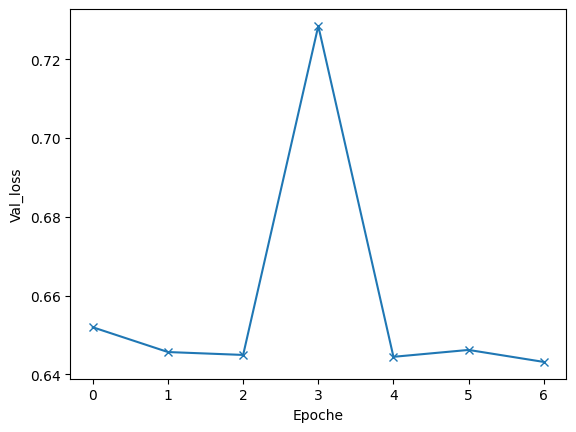

In [38]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('Epoche')
plt.ylabel('Val_loss')
#plt.title('Val_loss vs. No. di Epoche')

Text(0, 0.5, 'accuracy')

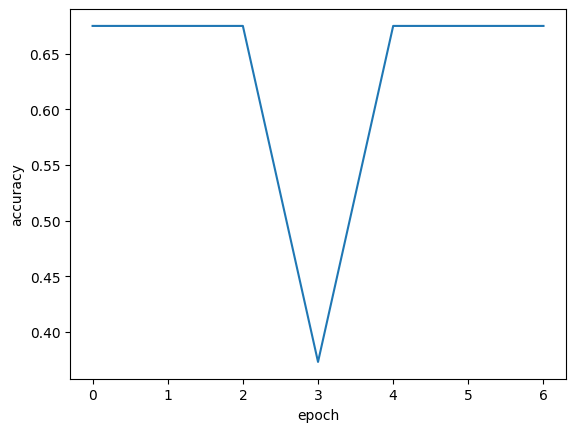

In [39]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-')
plt.xlabel('epoch')
plt.ylabel('accuracy')
#plt.title('Accuracy vs. No. of epochs');

Text(0, 0.5, 'precision')

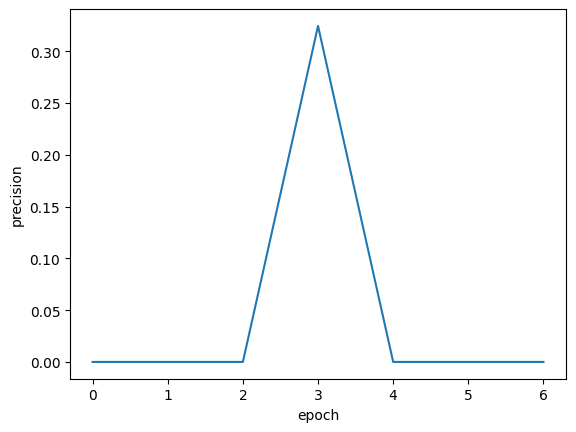

In [40]:
precision1 = [x['val_prec'] for x in history]
plt.plot(precision1, '-')
plt.xlabel('epoch')
plt.ylabel('precision')
#plt.title('precision vs. No. of epochs');

## Testing

In [41]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    elif isinstance(data, dict):
        return {key: to_device(value, device) for key, value in data.items()}
    elif isinstance(data, torch.Tensor):  # Assicurati che data sia un tensore PyTorch
        return data.to(device, non_blocking=True)
    else:
        return data  # Gestisci altri tipi di dati senza modificarli


In [42]:
test_loader = DeviceDataLoader(DataLoader(test_ds, batch_size=2*batch_size), device)

result = evaluate(model, test_loader)
result

accuracy labels:  tensor([0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       device='cuda:0')
accuracy preds:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')

precision targets:  tensor([0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       device='cuda:0')

precision preds:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')


<ipython-input-27-b99f2a086561>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_preds = torch.eq(torch.tensor(preds), torch.tensor(class_index))
<ipython-input-27-b99f2a086561>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_labels = torch.eq(torch.tensor(labels), torch.tensor(class_index)) #stessa cosa, confronta labels e class index, se sono uguali true(1), diversi false(0)


accuracy labels:  tensor([1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
accuracy preds:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

precision targets:  tensor([1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')

precision preds:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


{'val_loss': 0.6501253843307495,
 'val_acc': 0.6192307472229004,
 'val_prec': 0.0}